# Create Strips of Stop and Stare Data for Reconstruction
This notebook takes a list of existing datasets and performs registration and reconstruction of each stop-and-stare dataset in the stack

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset
import libwallerlab.utilities.noise as noise

# Platform imports
import os, glob
import numpy as np

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt

yp.config.setDefaultBackend('numpy')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [5]:
# Define user for path setting
# dataset_path = '/Users/zfphil/datasets/motiondeblur/'
dataset_path = '/Volumes/Datasets/einstein_data/'

# Define output directory
# output_directory = '/Users/zfphil/datasets/motiondeblur/learning_data_fixed/'
output_directory = '/Volumes/Datasets/learning_data_fixed/'

# Whether to use existing kernel
use_existing_kernel = True

# Find files in this directory
folder_list = glob.glob(os.path.join(dataset_path, '*/'))
dataset_list = [folder for folder in folder_list if isDataset(folder)]

# Select only the stop and stare datasets
sns_dataset_list = [folder_name for folder_name in folder_list if 'stopandstare' in folder_name]
coded_dataset_list = [folder_name for folder_name in folder_list if 'coded' in folder_name]

# Select res target (for debugging)
sns_dataset_list = [s for s in sns_dataset_list if '20x' not in s]
# sns_dataset_list = [s for s in sns_dataset_list if 'res' in s]
# coded_dataset_list = [s for s in coded_dataset_list if 'res' in s]

# Select dataset (for now)
dataset_index = 0

# Create dataset object for stop and stare
dataset = Dataset(sns_dataset_list[dataset_index])
dataset.metadata.type = 'motiondeblur'
dataset.channel_mask = [0]
md.preprocess(dataset)

# Get linear segment count
linear_segment_count = len(dataset.position_segment_indicies)
# linear_segment_count_coded = len(dataset_coded.position_segment_indicies)
# assert linear_segment_count_coded == linear_segment_count


IndexError: list index out of range

## Generate Blur Vector And Dimensionality

In [204]:
import scipy as sp
import numpy as np
import libwallerlab.utilities.noise as noise
downsample_factor = 8
compress_output = True
blur_kernel_fov_fraction = 0.2
frame_overlap_fraction = 0.25
blur_axis = 1
blur_direction = 'left'
debug=True

# Define noise models. Dict items are kwargs for libwallerlab.utilities.noise.add()
noise_models = {'gaussian': {'snr': 255}}

# Get frame shape
frame_shape = [sp.fftpack.next_fast_len(int(sz / downsample_factor)) for sz in dataset.frame_shape]

# Get measurement shap3
blur_vector_length = int((blur_kernel_fov_fraction * frame_shape[blur_axis]))

# Determine primary measurement shape
measurement_shape = yp.dcopy(frame_shape)
measurement_shape[blur_axis] = frame_shape[blur_axis] - blur_vector_length + 1
measurement_start = [0, 0]

# Determine shape of overlap
overlap_shape = yp.dcopy(frame_shape)
overlap_shape[blur_axis] = int(frame_shape[blur_axis] * frame_overlap_fraction)
overlap_start = [0, 0]
overlap_start[blur_axis] = frame_shape[blur_axis] - overlap_shape[blur_axis] -blur_vector_length

# Get ground truth shape
ground_truth_shape = yp.dcopy(frame_shape)
ground_truth_shape[blur_axis] = measurement_shape[blur_axis] - overlap_shape[blur_axis]
ground_truth_start = [0, blur_vector_length]

if debug:
    print('Frame shape is %s' % str(frame_shape))
    print('Blur vector length is %d' % blur_vector_length)
    print('Measurement shape is %s' % str(measurement_shape))
    print('Overlap shape is %s' % str(overlap_shape))
    print('Ground Truth shape is %s' % str(ground_truth_shape))

# Calculate size of first (left) frame
frame_1_shape = measurement_shape
frame_1_start = measurement_start

# Calculate size of first (left) frame
frame_2_shape = overlap_shape
frame_2_start = overlap_start

# Generate blurring function and decimate
if not use_existing_kernel:
    blur_kernel = md.blurkernel.generate(frame_shape, blur_vector_length, axis=blur_axis, 
                                         position='center_' + blur_direction, method='random_phase')
else:
    blur_vector = np.array([[0.84210526, 0.84210526, 0.84210526, 0.84210526, 0.        ,
        0.84210526, 0.        , 0.84210526, 0.        , 0.84210526,
        0.84210526, 0.84210526, 0.84210526, 0.        , 0.84210526,
        0.        , 0.        , 0.84210526, 0.        , 0.        ,
        0.84210526, 0.        , 0.        , 0.84210526, 0.84210526,
        0.84210526, 0.84210526, 0.84210526, 0.        , 0.        ,
        0.        , 0.84210526]])
    
    blur_kernel = md.blurkernel.fromVector(blur_vector, frame_shape, axis=blur_axis, position='center_' + blur_direction)
    
# Normalize
blur_kernel /= yp.sum(blur_kernel)

# Also crop blur kernel for storage in output file
blur_kernel_crop = yp.crop_to_support(blur_kernel)

Frame shape is [135, 160]
Blur vector length is 32
Measurement shape is [135, 129]
Overlap shape is [135, 40]
Ground Truth shape is [135, 89]


# Loop over datasets and create data

In [205]:
for dataset_path in sns_dataset_list:
    
    # Create dataset object for stop and stare
    dataset = Dataset(dataset_path)
    dataset.metadata.type = 'motiondeblur'
    dataset.channel_mask = [0]
    md.preprocess(dataset)

    # Get linear segment count
    linear_segment_count = len(dataset.position_segment_indicies)

    # Loop over measurements and generate datapoints
    for frame_index in yp.display.progressBar(range(len(dataset._frame_list)), name='Frames Saved'):
        # Clear all frames from memory
        dataset._frame_list = [None] * len(dataset._frame_list)

        # Set frame mask
        dataset.frame_mask = [frame_index]

        # Load frame
        frame = dataset.frame_list[0]

        # Decimite frame
        frame_decimated = yp.filter.decimate(frame, downsample_factor)

        # Convolve with blurring function ('valid' keyword crops kernel to )
        frame_convolved = yp.convolve(frame_decimated, blur_kernel, mode='same', padded=False)

        # Crop first frame's roi
        frame_1 = yp.crop(frame_convolved, frame_1_shape, frame_1_start)

        # Crop to second frame's ROI
        frame_2 = yp.crop(frame_convolved, frame_2_shape, frame_2_start)

        # Add noise to measurements
        for noise_mode in noise_models:
            frame_1 = noise.add(frame_1, noise_mode, **noise_models[noise_mode])
            frame_2 = noise.add(frame_2, noise_mode, **noise_models[noise_mode])

        # Generate ground truth image with correct support
        ground_truth = yp.crop(frame_decimated, ground_truth_shape, ground_truth_start)

        # Recover using gradient descent

        # Average measurements
        coverage_weights = yp.zeros(measurement_shape)
        coverage_weights[frame_1_roi.slice] += 1.0
        coverage_weights[frame_2_roi.slice] += 1.0
        measurements = (yp.pad(frame_1, measurement_shape, frame_1_roi.start) + yp.pad(frame_2, measurement_shape, frame_2_roi.start)) / coverage_weights

        # Create blur kernel with the correct position in the frame
        _blur_kernel = md.blurkernel.fromVector(blur_vector, yp.shape(measurements), position='center_right')
        _blur_kernel /= yp.sum(_blur_kernel)
        # Generate operators
        import ndoperators as ops
        CR = ops.Crop(measurement_shape, ground_truth_shape, crop_start=(0,0), dtype=dtype)
        C = ops.Convolution(_blur_kernel, dtype=dtype)
        C.inverse_regularizer=1e-3

        A = C
        y = measurements

        # Define deconvolution method
        method = 'gd'

        if method == 'gd':
            objective = ops.solvers.objectivefunctions.L2(A, y)

            gd = ops.solvers.Fista(objective, display_type=None)
            x_opt = CR * gd.solve(iteration_count=100, step_size=0.1)

        elif method == 'direct':

            C.inverse_regularizer = 1e-6
            x_opt = CR * C.inv * y


        # Generate output filename
        _dir = os.path.join(output_directory, dataset.metadata.file_header) + '_%d' % frame_index

        # Define data structure
        data = {'ground_truth': {'array': ground_truth, 'start': (0,0)},
                'reconstruction': {'array': x_opt, 'start': (0,0)},
                'measurements': [{'array': frame_1, 'start': frame_1_start},
                                 {'array': frame_2, 'start': frame_2_start}],
                'metadata': {'blur_direction': blur_direction, 
                             'blur_axis': blur_axis,
                             'blur_kernel_fov_fraction': blur_kernel_fov_fraction,
                             'frame_overlap_fraction': frame_overlap_fraction,
                             'measurement_shape': measurement_shape,
                             'ground_truth_shape': ground_truth_shape},
                'blur_vector': {'array': blur_kernel_crop, 'start': yp.boundingBox(blur_kernel)[0]}}

        # Save data
        if compress_output:
            np.savez_compressed(_dir, data)
        else:
            np.savez(_dir, data)

Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...
Loading 1 frames...


IndexError: list index out of range

## Load and Display a Data Point

In [202]:
_dir

'/Volumes/Datasets/lerning_data_fixed/123a_color_stopandstare_raster_multi_contrast_2018_05_23_08_15_21_0'

<IPython.core.display.Javascript object>


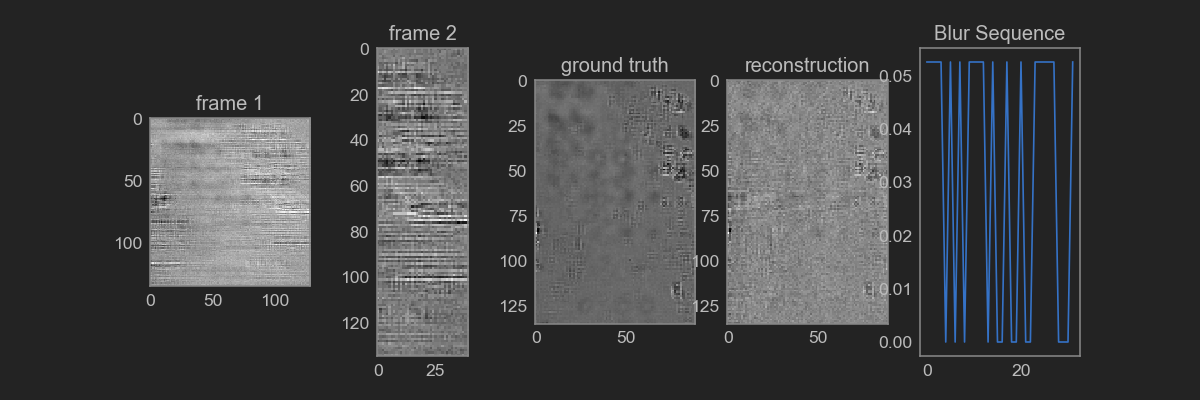

Text(0.5, 1.0, 'Blur Sequence')

In [194]:
# Set data point index here
frame_index = 4

# Find frames
files = list(glob.glob(output_directory + '*.npz'))
files.sort()

# Load data point (second line deals with weird structuring of .npz files)
_data = dict(np.load(files[frame_index]))
data = {key:_data[key].item() for key in _data}['arr_0']

plt.figure()
plt.subplot(151)
plt.imshow(yp.real(data['measurements'][0]['array']))
plt.title('frame 1')
plt.subplot(152)
plt.imshow(yp.real(data['measurements'][1]['array']))
plt.title('frame 2')
plt.subplot(153)
plt.imshow(yp.real(data['ground_truth']['array']))
plt.title('ground truth')
plt.subplot(154)
plt.imshow(yp.real(data['reconstruction']['array']))
plt.title('reconstruction')
plt.subplot(155)
plt.plot(yp.real(np.squeeze(data['blur_vector']['array'])))
plt.title('Blur Sequence')


# Deconvolve Single Data Point

In [6]:
# Set data point index here
frame_index = 13
dtype='complex32'

# Find frames
files = list(glob.glob(output_directory + '*.npz'))
files.sort()

# Load data point (second line deals with weird structuring of .npz files)
_data = dict(np.load(files[frame_index]))
data = {key:_data[key].item() for key in _data}['arr_0']

blur_vector = data['blur_vector']['array']
measurement_shape = data['metadata']['measurement_shape']
ground_truth_shape = data['metadata']['ground_truth_shape']
blur_axis = data['metadata']['blur_axis']
blur_direction = data['metadata']['blur_direction']

frame_1 = data['measurements'][0]['array']
frame_2 = data['measurements'][1]['array']
ground_truth = data['ground_truth']['array']

# Get ROIs
frame_1_roi = yp.Roi(start=data['measurements'][0]['start'], shape=yp.shape(frame_1))
frame_2_roi = yp.Roi(start=data['measurements'][1]['start'], shape=yp.shape(frame_2))

# Average measurements
coverage_weights = yp.zeros(measurement_shape)
coverage_weights[frame_1_roi.slice] += 1.0
coverage_weights[frame_2_roi.slice] += 1.0
measurements = (yp.pad(frame_1, measurement_shape, frame_1_roi.start) + yp.pad(frame_2, measurement_shape, frame_2_roi.start)) / coverage_weights
# measurements = frame_1
# Create blur kernel with the correct position in the frame
blur_kernel = md.blurkernel.fromVector(blur_vector, yp.shape(measurements), position='center_right')

# Generate operators
import ndoperators as ops
CR = ops.Crop(measurement_shape, ground_truth_shape, crop_start=(0,0), dtype=dtype)
C = ops.Convolution(blur_kernel, dtype=dtype)
C.inverse_regularizer=1e-3

A = C
y = measurements

# Define deconvolution method
method = 'direct'

if method == 'gd':
    objective = ops.solvers.objectivefunctions.L2(A, y)
#     objective += 1e-2 * ops.solvers.regularizers.WaveletSparsity(measurement_shape)
#     objective += 1e-4 * ops.solvers.regularizers.L2(measurement_shape)
    gd = ops.solvers.Fista(objective)
    x_opt = CR * gd.solve(iteration_count=500, step_size=1)
    
elif method == 'direct':
    
#     plt.figure()
#     plt.imshow(yp.real(yp.deconvolve(y, blur_kernel, reg=1e-3)))
#     C.inverse_regularizer = 1e-2
#     x_opt = CR * yp.real(yp.deconvolve(y, blur_kernel, reg=1e-3))
    C.inverse_regularizer = 1e-6
    x_opt = CR * C.inv * y
#     x_opt = CR * yp.real(yp.deconvolve(y, blur_kernel, reg=1e-3))

plt.figure()
plt.subplot(141)
plt.imshow(yp.abs(y))
plt.title('Raw')
plt.subplot(142)
plt.imshow(yp.abs(x_opt))
plt.title('Recovered')
plt.subplot(143)
plt.imshow(yp.abs(ground_truth))
plt.title('True')
plt.subplot(144)
plt.imshow(yp.real(ground_truth - x_opt))
plt.title('Error')

IndexError: list index out of range

<IPython.core.display.Javascript object>


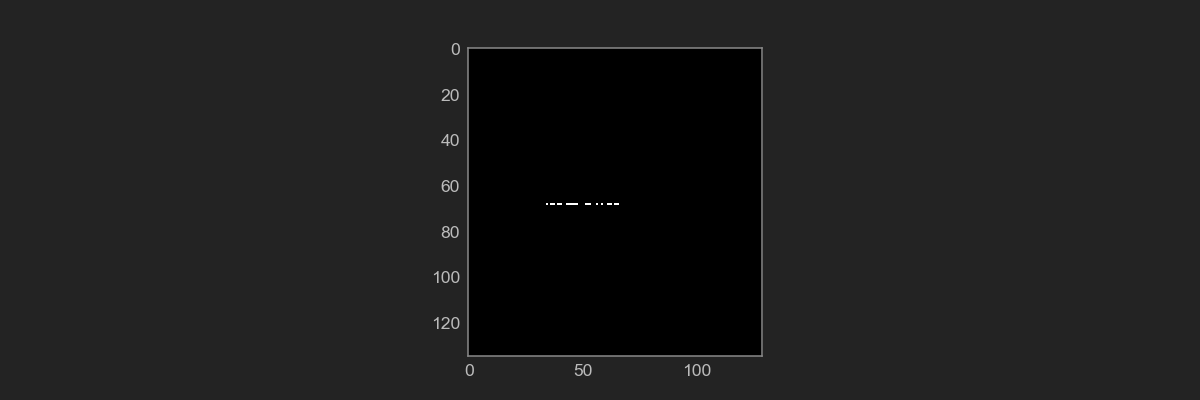

In [69]:
plt.figure()
plt.imshow(yp.real(blur_kernel))

In [ ]:
C = ops.Convolution(blur_kernel)
h_ft = yp.Ft(blur_kernel)
h_inv = yp.conj(h_ft) / (yp.abs(h_ft) ** 2 + 1e-3)
y_ft = yp.Ft(y)
plt.figure()
plt.subplot(141)
plt.imshow(yp.real(yp.deconvolve(y, blur_kernel, reg=1e-3)))
plt.subplot(142)
plt.imshow(yp.real(yp.convolve(y_ft, h_inv, fourier_inputs=True)))
plt.subplot(143)
plt.imshow(yp.real(C.inv * y))
plt.subplot(144)
plt.imshow(yp.real((C.inv * y) / yp.deconvolve(y, blur_kernel, reg=1e-3)))

## Used for Generating Figure

In [ ]:
frame_indicies = range(10, 15)
fig_output_dir = '/Users/zfphil/Desktop/'

# Find frames
files = list(glob.glob(output_directory + '*.npz'))
files.sort()

for frame_index in frame_indicies:

    # Load data point (second line deals with weird structuring of .npz files)
    _data = dict(np.load(files[frame_index]))
    data = {key:_data[key].item() for key in _data}['arr_0']

    plt.figure(figsize=(6,6))
    plt.imshow(yp.real(data['measurements'][0]['array']))
    plt.axis('off')
    plt.savefig(fig_output_dir + 'meas_' + str(frame_index), transparent=True)
    
    plt.figure(figsize=(6,6))
    plt.imshow(yp.real(data['ground_truth']['array']))
    plt.axis('off')
    plt.savefig(fig_output_dir + 'gt_' + str(frame_index), transparent=True)

    blur_vector = data['blur_vector']['array']
    measurement_shape = data['metadata']['measurement_shape']
    ground_truth_shape = data['metadata']['ground_truth_shape']
    blur_axis = data['metadata']['blur_axis']
    blur_direction = data['metadata']['blur_direction']

    frame_1 = data['measurements'][0]['array']
    frame_2 = data['measurements'][1]['array']
    ground_truth = data['ground_truth']['array']

    # Get ROIs
    frame_1_roi = yp.Roi(start=data['measurements'][0]['start'], shape=yp.shape(frame_1))
    frame_2_roi = yp.Roi(start=data['measurements'][1]['start'], shape=yp.shape(frame_2))

    # Average measurements
    coverage_weights = yp.zeros(measurement_shape)
    coverage_weights[frame_1_roi.slice] += 1.0
    coverage_weights[frame_2_roi.slice] += 1.0
    measurements = (yp.pad(frame_1, measurement_shape, frame_1_roi.start) + yp.pad(frame_2, measurement_shape, frame_2_roi.start)) / coverage_weights

    # Create blur kernel with the correct position in the frame
    # blur_kernel_crop = yp.roll(md.blurkernel.fromVector(blur_vector, measurement_shape, axis=blur_axis, position='center_' + blur_direction), (-1, 2))
    import math
    blur_kernel_crop = yp.roll(yp.pad(blur_vector, measurement_shape, center=True), (0, -math.ceil(yp.size(blur_vector) / 2) + 3))
    # Generate operators
    import ndoperators as ops
    CR = ops.Crop(measurement_shape, ground_truth_shape, crop_start=(0,0))
    C = ops.Convolution(blur_kernel_crop, dtype='complex32', mode='circular')
    y = measurements

    # Define deconvolution method
    method = 'direct'

    if method == 'gd':
        objective = ops.solvers.objectivefunctions.L2(C, y)
        gd = ops.solvers.GradientDescent(objective)
        x_opt = CR * gd.solve(iteration_count=1000, step_size=1e-3)

    elif method == 'direct':
        C.inverse_regularizer = 1e-1
        x_opt = CR * C.inv * y
        
        
    plt.figure(figsize=(6,6))
    plt.imshow(yp.real(x_opt))
    plt.axis('off')
    plt.savefig(fig_output_dir + 'decon_' + str(frame_index), transparent=True)